# Заранее прошу меня простить за то что использовал Keras, а не pyTorch, как было рекомендовано, потому что я был очень ограничен во времени этой недели из-за переезда. 
### В дальнейшем, думаю, не составит труда освоить pyTorch или перенести данную модель на него.

In [88]:
# Важные импорты 
import keras
import tensorflow
import matplotlib.pyplot as plt
import numpy as np
import os

In [39]:
# Определяю путь к папке с тренировочными данными (в данном случае и ноутбук, и папка лежат в одной директории)
base_dir = 'internship_data'
male_dir = os.path.join(base_dir, 'male')
female_dir =  os.path.join(base_dir, 'female')

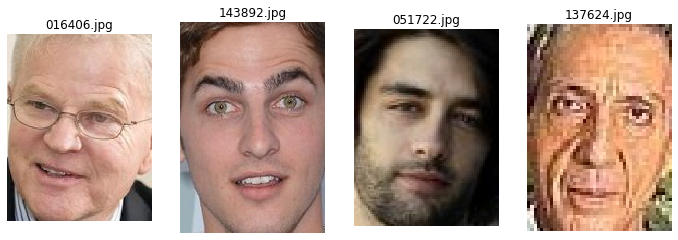

In [40]:
# Посмотрим на изображения мужчин 

selected = np.random.choice(sorted(os.listdir(male_dir)),4)

plt.figure(figsize=(15, 15))    
for i in range(len(selected)):
    plt.subplot(3,5,i+1)
    new_dir = os.path.join(male_dir)
    rnd_img = np.random.choice(os.listdir(new_dir))
    img = plt.imread(os.path.join( new_dir, rnd_img))
    plt.imshow(img)
    plt.title(selected[i])
    plt.axis('off') 

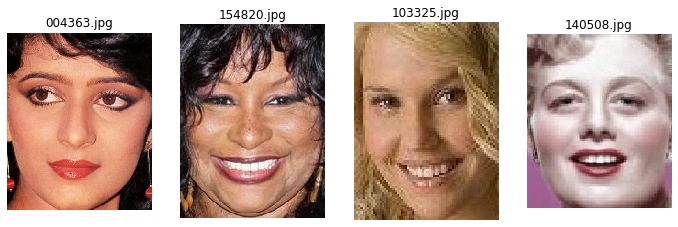

In [41]:
#...и женщин 

selected = np.random.choice(sorted(os.listdir(female_dir)),4)

plt.figure(figsize=(15, 15))    
for i in range(len(selected)):
    plt.subplot(3,5,i+1)
    new_dir = os.path.join(female_dir)
    rnd_img = np.random.choice(os.listdir(new_dir))
    img = plt.imread(os.path.join( new_dir, rnd_img))
    plt.imshow(img)
    plt.title(selected[i])
    plt.axis('off') 

In [42]:
# Для увеличения количества данных для обучения данные аугментированы
datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,rotation_range=0.5,rescale=1./255,zoom_range=0.5,validation_split=0.05)

In [43]:
# Определяю данные для тренировочного и валидационного сета
train_generator_iter = datagen.flow_from_directory(base_dir,
        target_size=(150, 100),
        batch_size=15,
        class_mode='categorical',
        subset='training')

val_generator_iter= datagen.flow_from_directory(base_dir,
        target_size=(150, 100),
        batch_size=15,
        class_mode='categorical',
        subset='validation')

Found 95009 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [44]:
#Определяю архитектуру CNN. Все слои имеют функцию активации ReLU, кроме последнего.
from keras import layers
from keras import models
from keras import optimizers

face = models.Sequential()
face.add(keras.layers.Conv2D(filters=32,kernel_size=(5, 5), activation='relu',input_shape=(150, 100, 3)))
face.add(keras.layers.MaxPooling2D((2, 2)))
face.add(keras.layers.Conv2D(filters=64,kernel_size=(3, 3), activation='relu'))
face.add(keras.layers.Conv2D(filters=64,kernel_size=(3, 3), activation='relu'))
face.add(keras.layers.MaxPooling2D(2,2))
face.add(keras.layers.Conv2D(filters=128,kernel_size=(3, 3), activation='relu'))
face.add(keras.layers.MaxPooling2D(2,2))
face.add(keras.layers.Flatten())
face.add(keras.layers.Dense(512, activation='relu'))
face.add(keras.layers.Dense(2, activation='softmax'))
face.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 146, 96, 32)       2432      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 73, 48, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 71, 46, 64)        18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 69, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 34, 22, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 10, 128)      

In [45]:
# Скомпилирую модель 
face.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.RMSprop(lr = 1e-4, decay = 1e-6), metrics= ['acc'])

In [59]:
# Загрузка модели на случай повторного обучения или проверки модели
face.load_weights('/Users/vitalij/Downloads/sex.h5')

In [48]:
# И начинается обучение. В данном случае обучил на 5 эпохах, так как был ограничен в ресурсах 
# Коллаб выдавал время на обучение эпохи около 7 часов, хотя на моем компьютере это заняло около 40 минут
face.fit(train_generator_iter,
                          epochs=5,
                          validation_data = val_generator_iter,
                          verbose=1,
                          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/5
6334/6334 [==============================] - 2521s 398ms/step - loss: 0.2425 - acc: 0.9015 - val_loss: 0.2385 - val_acc: 0.9124
Epoch 2/5
6334/6334 [==============================] - 2468s 390ms/step - loss: 0.1937 - acc: 0.9244 - val_loss: 0.1854 - val_acc: 0.9302
Epoch 3/5
6334/6334 [==============================] - 2556s 404ms/step - loss: 0.1827 - acc: 0.9300 - val_loss: 0.1845 - val_acc: 0.9274
Epoch 4/5
6334/6334 [==============================] - 2668s 421ms/step - loss: 0.1772 - acc: 0.9333 - val_loss: 0.1598 - val_acc: 0.9380
Epoch 5/5
6334/6334 [==============================] - 2544s 402ms/step - loss: 0.1745 - acc: 0.9347 - val_loss: 0.2462 - val_acc: 0.9006


In [56]:
#Сохраняю модель
face.save_weights('/Users/vitalij/Downloads/sex.h5')

In [64]:
#Приблизительные показатели обученной модели
loss,ac = face.evaluate_generator(generator=val_generator_iter,steps=10,use_multiprocessing=False)
print('Loss: {:.8}'.format(loss))
print('Accuracy: {:.2%}'.format(ac))

Loss: 0.2263952
Accuracy: 90.67%


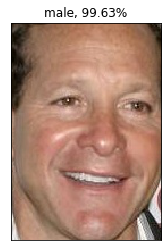

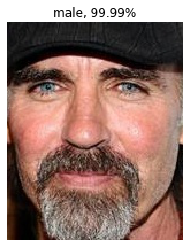

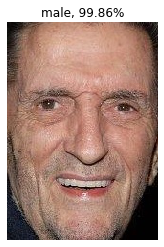

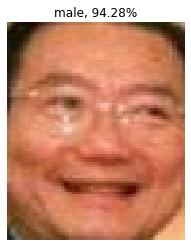

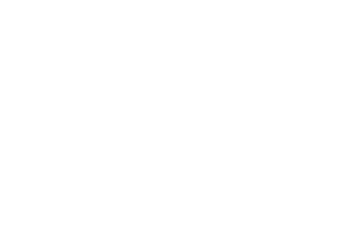

In [77]:
#Проверка работы модели на мужских изображениях 

selected = np.random.choice(sorted(os.listdir(male_dir)),4)

   
for i in range(len(selected)):
    
    new_dir = os.path.join(male_dir)
    rnd_img = np.random.choice(os.listdir(new_dir))
    path = os.path.join( new_dir, rnd_img)
    img = plt.imread(path)
    
    load_img = keras.preprocessing.image.load_img(path=path, target_size=(150,100,3))
    array = keras.preprocessing.image.img_to_array(load_img) / 255
    img_array = np.expand_dims(array, axis = 0)
    predictions = face.predict(img_array)
    
    index = np.argmax(predictions[0])
    label = list(train_generator_iter.class_indices.keys())[index]
    pred= ["{:.2f}%".format(j * 100) for j in predictions[0] ]
    
    title = label+', '+str(pred[index]) 
    plt.title(title)
    
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    plt.axis('off')

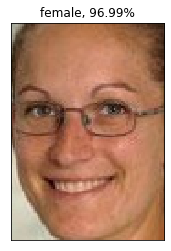

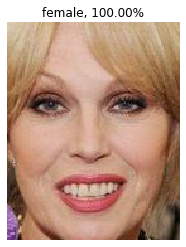

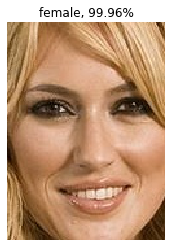

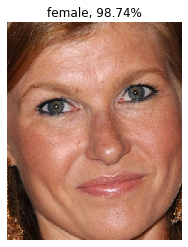

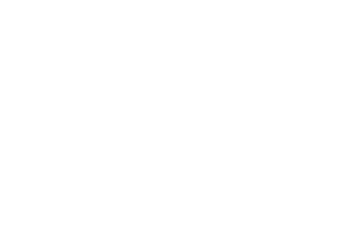

In [79]:
# А теперь на женских

selected = np.random.choice(sorted(os.listdir(female_dir)),4)

   
for i in range(len(selected)):
    
    new_dir = os.path.join(female_dir)
    rnd_img = np.random.choice(os.listdir(new_dir))
    path = os.path.join( new_dir, rnd_img)
    img = plt.imread(path)
    
    load_img = keras.preprocessing.image.load_img(path=path, target_size=(150,100,3))
    array = keras.preprocessing.image.img_to_array(load_img) / 255
    img_array = np.expand_dims(array, axis = 0)
    predictions = face.predict(img_array)
    
    index = np.argmax(predictions[0])
    label = list(train_generator_iter.class_indices.keys())[index]
    pred= ["{:.2f}%".format(j * 100) for j in predictions[0] ]
    
    title = label+', '+str(pred[index]) 
    plt.title(title)
    
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    plt.axis('off')